In [1]:
!nvidia-smi --list-gpus

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-b3420b31-4832-b27f-df3a-6215a94894aa)


In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version:", tf.__version__)
print(device_lib.list_local_devices())

Num GPUs Available:  1
Tensorflow version: 2.5.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 82175258191160068
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9392422912
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10859955885065452682
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0b:00.0, compute capability: 7.5"
]


### Downloading the Data
Ensure that you have uploaded the dataset to the colab environment.

In [3]:
# !python -m pip install gdown --quiet

import os

if not os.path.exists("animals.zip"):
    import gdown
    url = 'https://drive.google.com/uc?id=18pulZkIQzDHGkH-UrDzxHp_giSxerTag'
    # url = 'https://drive.google.com/uc?id=1ImrsoqvQ3JC-iGW2znQmfkoZyL5E3icJ'
    # url = 'https://drive.google.com/uc?id=1S-OJVgxKXDeS5gmqJwzUaCpXmuT4zWcu'
    output = 'animals.zip'
    gdown.download(url, output, quiet=True)

In [4]:
"""
Unzip files if they don't exist
"""
if not os.path.exists("cats-dogs-wolves-"):
    !unzip animals.zip
    print("Done.")

In [5]:
!find . -name ".DS_Store" -type f -delete

train_path = 'cats-dogs-wolves-/datasets'
test_path = 'cats-dogs-wolves-/testData'
print("Paths Loaded.")

Paths Loaded.


Access denied - .
File not found - -NAME
File not found - -TYPE
File not found - F
File not found - -DELETE


### Importing the Software Libraries

The following code imports some software libraries necessary to execute the project. 

In [6]:
# If in colab
if "google.colab" in str(get_ipython()):
    %tensorflow_version 2.x  # Uncomment for colab

import numpy as np
import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

from sklearn.metrics import confusion_matrix
# from mlxtend.evaluate import confusion_matrix  # Use this if using colab I think
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
print("Import Success!")

Import Success!


In [7]:
SEED = 24

BATCH_SIZE_TRAIN = 15
BATCH_SIZE_VALIDATE = 8
BATCH_SIZE_TEST = 133

In [8]:
image_size = (224, 224)
classes = ['cats', 'dogs', 'wolves']

train_datagen = ImageDataGenerator(
    # validation_split=0.20,  # set validation split
    validation_split=0,
) 

train_batches = train_datagen.flow_from_directory(
    train_path,
    image_size,
    classes=classes,
    batch_size=BATCH_SIZE_TRAIN,
    subset='training',
    seed=SEED
)

valid_batches = train_datagen.flow_from_directory(
    train_path,
    image_size,
    classes=classes,
    batch_size=BATCH_SIZE_VALIDATE,
    subset='validation',
    seed=SEED
)

test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    image_size,
    classes=classes,
    batch_size=BATCH_SIZE_TEST,
    seed=SEED

)

Found 362 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


In [9]:
vgg16_model = tensorflow.keras.applications.VGG16()

### Creating a Custom Output Model#

A new model is created copying all layers except the output layer. Notice that these layers are set to be non-trainable. Finally, a custom output layer is added to the model.  This output layer should have the same number of outputs as the number of different classes of data. The softmax activation function conditions the output to be a probability distribuiton adding up to unity. Therefore, our model will output a probability distribution among the classes as output for each input image.

In [10]:
from pprint import pprint

from tensorflow.keras import regularizers

# Make a new model
model = Sequential()

# Copy every layer except the last layer of the vgg16 model
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

"""
Set the layers in the new model to not trainable

Notes:
    Recall that layers be default are trainable
    Retraining the last 2 layers, fc1 and fc2, is not a good idea unless you have a lot of data
"""
for layer in model.layers:
    layer.trainable = False

    
# Additional layer if needed
model.add(Dense(2048,
                activation='elu',
                # activity_regularizer=regularizers.l2(.05)  # Regularization seems like a bad idea since we still don't get good results
                )
          )

# model.add(Dense(2048,
#                 activation='relu',
#                 activity_regularizer=regularizers.l2(1e-4)
#                 )
#           )

# Add a new dense layer (This layer will be trained)
model.add(Dense(len(classes), activation='softmax'))


for layer in model.layers:
    print("{:<20}{:<10}{:<70}{}".format(layer.name,
                                        str(layer.get_config().get('activation')),
                                        str(layer.get_config().get('activity_regularizer')),
                                        layer.trainable)
          )

model.summary()

block1_conv1        relu      None                                                                  False
block1_conv2        relu      None                                                                  False
block1_pool         None      None                                                                  False
block2_conv1        relu      None                                                                  False
block2_conv2        relu      None                                                                  False
block2_pool         None      None                                                                  False
block3_conv1        relu      None                                                                  False
block3_conv2        relu      None                                                                  False
block3_conv3        relu      None                                                                  False
block3_pool         None      None            

## Training the Model

Now that the model has been specified, it must be trained. 




### Compiling the Model
First,the model is compiled. The performance of the model is evalued using a loss function, which increases as performance decreases. Since we are predicting a condition (yes/no), we are using cross-entropy, which is a concept from information theory. If we were instead predicting a scalar value, the correct loss function would be 'mean_squared_error'.

In [11]:
model.compile(Adam(learning_rate=.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("Done")

Done


### Minimizing Loss

The model is now trained using the backpropagation algorithm to minimize the loss function. The training data will be passed into the model and evaluated using the loss function. Then, the model will be adjusted to decrease the loss.

Here we specifiy the epochs, which is the number of times we pass through the entire training set. These specifications are determined by experimentation with the goal of minimizing validation loss. If the epochs are too high, the model has overfit to the data (too specific). If the epochs are too low, the model has underfit to the data (too general). The validation loss must be compared to training loss to determine if the model is optimally fit to the data.


In [12]:
%timeit

model.fit(
    train_batches,
    validation_data=valid_batches,
    steps_per_epoch=train_batches.samples // BATCH_SIZE_TRAIN,
    validation_steps=valid_batches.samples // BATCH_SIZE_VALIDATE,
    epochs=200,  # Was 30
    verbose=1)
print("Trining Complete!")

Epoch 1/200
24/24 [==============================] - 11s 81ms/step - loss: 0.4605 - accuracy: 0.8501
Epoch 2/200
24/24 [==============================] - 2s 68ms/step - loss: 0.0219 - accuracy: 0.9914
Epoch 3/200
24/24 [==============================] - 2s 65ms/step - loss: 0.0275 - accuracy: 0.9942
Epoch 4/200
24/24 [==============================] - 4s 110ms/step - loss: 6.2062e-04 - accuracy: 1.0000
Epoch 5/200
24/24 [==============================] - 2s 63ms/step - loss: 1.2963e-04 - accuracy: 1.0000
Epoch 6/200
24/24 [==============================] - 2s 65ms/step - loss: 9.7244e-05 - accuracy: 1.0000
Epoch 7/200
24/24 [==============================] - 2s 65ms/step - loss: 8.5447e-05 - accuracy: 1.0000
Epoch 8/200
24/24 [==============================] - 2s 62ms/step - loss: 5.8846e-05 - accuracy: 1.0000
Epoch 9/200
24/24 [==============================] - 3s 112ms/step - loss: 6.4515e-05 - accuracy: 1.0000
Epoch 10/200
24/24 [==============================] - 3s 111ms/step - los

## Testing the Model

To perform a final test of the model, the test data is fed through the model.  It is important to use data that was not used in training so we can test the performance accurately. The accuracy is calculated and a confusion matrix is generated. 

### Test Accuracy

To calculate accuracy, the model is evaluated using the test generator specified earlier.

In [13]:
test_loss, test_acc = model.evaluate(test_batches,
                                     steps=len(test_batches),
                                     verbose=0)
print(test_loss)
print(test_acc)

0.4330790042877197
0.9624060392379761


### Confusion Matrix

A confusion matrix gives more insight than just accuracy. It allows us to determine true positives, false positives, false negatives, and true negatives. The code below generates a confusion matrix for our test output

Found 133 images belonging to 3 classes.
Confusion matrix, without normalization
[[18  0  0]
 [ 1 58  2]
 [ 0  2 52]]


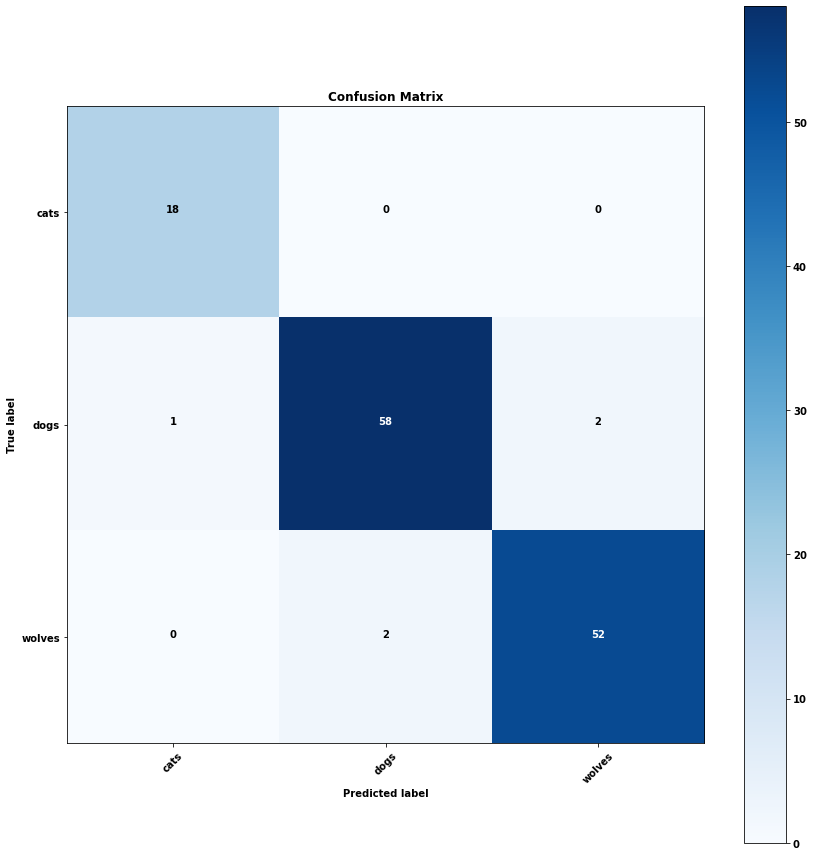

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, cm[i, j],
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")

    thresh = cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title + "_cat_dog_wolves")


# test_batches.reset()

# * Should this be random?
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(224, 224),
    shuffle=False,
    batch_size=BATCH_SIZE_TEST,
    # seed=SEED,
)

test_imgs, test_labels = next(test_batches)
# test_labels = test_labels[:,0]

predictions = model.predict(test_batches, 
                            steps=len(test_batches),
                            verbose=0)

# cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
cm = confusion_matrix(test_labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      # binary=False
                      )

cm_plot_labels = classes
plot_confusion_matrix(cm,
                      cm_plot_labels,
                      title='Confusion Matrix')

## Saving the fine-tuned VGG16 model

Now that the model has been trained and tested, it should be saved so we can classify new images without retraining.

In [15]:
def save_best_model(path_abs_model, model_given, test_batches_given, steps, optimzier=Adam(learning_rate=.0001), loss='categorical_crossentropy', metricts=['accuracy']):

    import tensorflow as tf
    import os

    model_given_test_loss, model_given_test_acc = model_given.evaluate(
        test_batches_given,
        steps=steps,
        verbose=1
    )

    # Save if there is no model to compare to
    if not os.path.exists(path_abs_model):
        print(f"Current model with acc ({model_given_test_acc}) is saved!")
        model_given.save(path_abs_model)
        return

    model_existing = tf.keras.models.clone_model(model_given)
    model_existing.load_weights(path_abs_model)

    model_existing.compile(optimzier,
                           loss=loss,
                           metrics=metricts)

    model_existing_test_loss, model_existing_test_acc = model_existing.evaluate(
        test_batches_given,
        steps=steps,
        verbose=1
    )

    # Save model given if it's better than the existing one
    if model_given_test_acc >= model_existing_test_acc:
        print(
            f"Current model with acc ({model_given_test_acc}) is better than Existing model with acc ({model_existing_test_acc}) and is saved!")
        model_existing.save(path_abs_model)

    else:
        print(
            f"Existing model with acc ({model_existing_test_acc}) is better than Current model with acc ({model_given_test_acc})")

In [16]:
save_best_model('weights_animals_VGG16_fine_tuned.h5', model, test_batches, len(test_batches))

1/1 [==============================] - 1s 1s/step - loss: 0.4800 - accuracy: 0.9624
Existing model with acc (0.9624060392379761) is better than Current model with acc (0.9624060392379761)


## Loading the fine-tuned VGG16 model

In a production environment, the model could be loaded.

In [17]:
model.load_weights('weights_animals_VGG16_fine_tuned.h5')
print("Model Loaded.")

Model Loaded.


## Conclusion

In this notebook, using transfer learning for image classification has been demonstrated. First, the data is uploaded and connected to the Keras API. Then, the model is defined by copying a pretrained model and adding a new output layer. Once defined, the model can be trained using the appropriate loss function. Finally, the model is evaluated using a test dataset. With minimal modification, the model can be used to predict multiple classes beyond two, as well as predicting scalar values. It is encouraged to use this notebook as a templete for similar models using novel datasets. 